1.Import Necessary Libraries

In [5]:
# 核心库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any, Optional
from collections import Counter
import os

# 数据增强库
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.utils import to_categorical
except ImportError:
    print("TensorFlow not available")

# 设置样式
plt.style.use('ggplot')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")

ModuleNotFoundError: No module named 'imblearn'

2. Load Processed Data

In [6]:
def load_processed_data(data_path: str = '../data/processed') -> Tuple:
    """加载预处理后的数据"""
    print("Loading processed data...")
    
    try:
        x_train = np.load(os.path.join(data_path, 'x_train.npy'))
        y_train = np.load(os.path.join(data_path, 'y_train.npy'))
        x_val = np.load(os.path.join(data_path, 'x_val.npy'))
        y_val = np.load(os.path.join(data_path, 'y_val.npy'))
        x_test = np.load(os.path.join(data_path, 'x_test.npy'))
        y_test = np.load(os.path.join(data_path, 'y_test.npy'))
        
        # 加载类别名称
        with open(os.path.join(data_path, 'class_names.txt'), 'r', encoding='utf-8') as f:
            class_names = [line.strip() for line in f.readlines()]
        
        print("Data loaded successfully!")
        print(f"Training shape: {x_train.shape}")
        print(f"Validation shape: {x_val.shape}")
        print(f"Test shape: {x_test.shape}")
        print(f"Class names: {class_names}")
        
        return x_train, y_train, x_val, y_val, x_test, y_test, class_names
        
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please run data collection script first")
        raise

# 加载数据
x_train, y_train, x_val, y_val, x_test, y_test, CLASS_NAMES = load_processed_data()

Loading processed data...
Data loaded successfully!
Training shape: (40000, 32, 32, 3)
Validation shape: (10000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


3. Analyze Class Distribution

In [8]:
def analyze_class_distribution(labels: np.ndarray, title: str) -> Dict[int, int]:
    """分析类别分布"""
    labels_flat = labels.flatten()
    class_dist = Counter(labels_flat)
    
    print(f"\n{title} Class Distribution:")
    print("-" * 40)
    for class_id in range(len(CLASS_NAMES)):
        count = class_dist.get(class_id, 0)
        percentage = (count / len(labels_flat)) * 100
        print(f"{CLASS_NAMES[class_id]:<12}: {count:>5} samples ({percentage:5.1f}%)")
    
    return class_dist

# 分析分布
train_dist = analyze_class_distribution(y_train, "Training")
val_dist = analyze_class_distribution(y_val, "Validation")
test_dist = analyze_class_distribution(y_test, "Test")



Training Class Distribution:
----------------------------------------
airplane    :  4000 samples ( 10.0%)
automobile  :  4000 samples ( 10.0%)
bird        :  4000 samples ( 10.0%)
cat         :  4000 samples ( 10.0%)
deer        :  4000 samples ( 10.0%)
dog         :  4000 samples ( 10.0%)
frog        :  4000 samples ( 10.0%)
horse       :  4000 samples ( 10.0%)
ship        :  4000 samples ( 10.0%)
truck       :  4000 samples ( 10.0%)

Validation Class Distribution:
----------------------------------------
airplane    :  1000 samples ( 10.0%)
automobile  :  1000 samples ( 10.0%)
bird        :  1000 samples ( 10.0%)
cat         :  1000 samples ( 10.0%)
deer        :  1000 samples ( 10.0%)
dog         :  1000 samples ( 10.0%)
frog        :  1000 samples ( 10.0%)
horse       :  1000 samples ( 10.0%)
ship        :  1000 samples ( 10.0%)
truck       :  1000 samples ( 10.0%)

Test Class Distribution:
----------------------------------------
airplane    :  1000 samples ( 10.0%)
automobile  

4. Data Augmentation Techniques

In [9]:
# ...existing code...
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.utils import to_categorical
    TF_AVAILABLE = True
except ImportError:
    print("TensorFlow not available")
    TF_AVAILABLE = False
# ...existing code...

if TF_AVAILABLE:
    def create_augmentation_generators() -> Dict[str, ImageDataGenerator]:
        """创建不同的数据增强生成器"""
        # 1. 基础增强
        base_augmentation = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )
        # 2. 强力增强
        strong_augmentation = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
        # 3. 仅水平翻转
        flip_only = ImageDataGenerator(horizontal_flip=True)
        # 4. 无增强（用于验证）
        no_augmentation = ImageDataGenerator()
        return {
            'base': base_augmentation,
            'strong': strong_augmentation,
            'flip_only': flip_only,
            'none': no_augmentation
        }
    # 创建增强生成器
    augmentation_generators = create_augmentation_generators()
    print("Augmentation generators created!")
else:
    print("无法创建数据增强生成器，因为 TensorFlow 未安装。")
# ...existing code...

Augmentation generators created!


5. Visualize Augmented Images

Visualizing augmentation techniques...


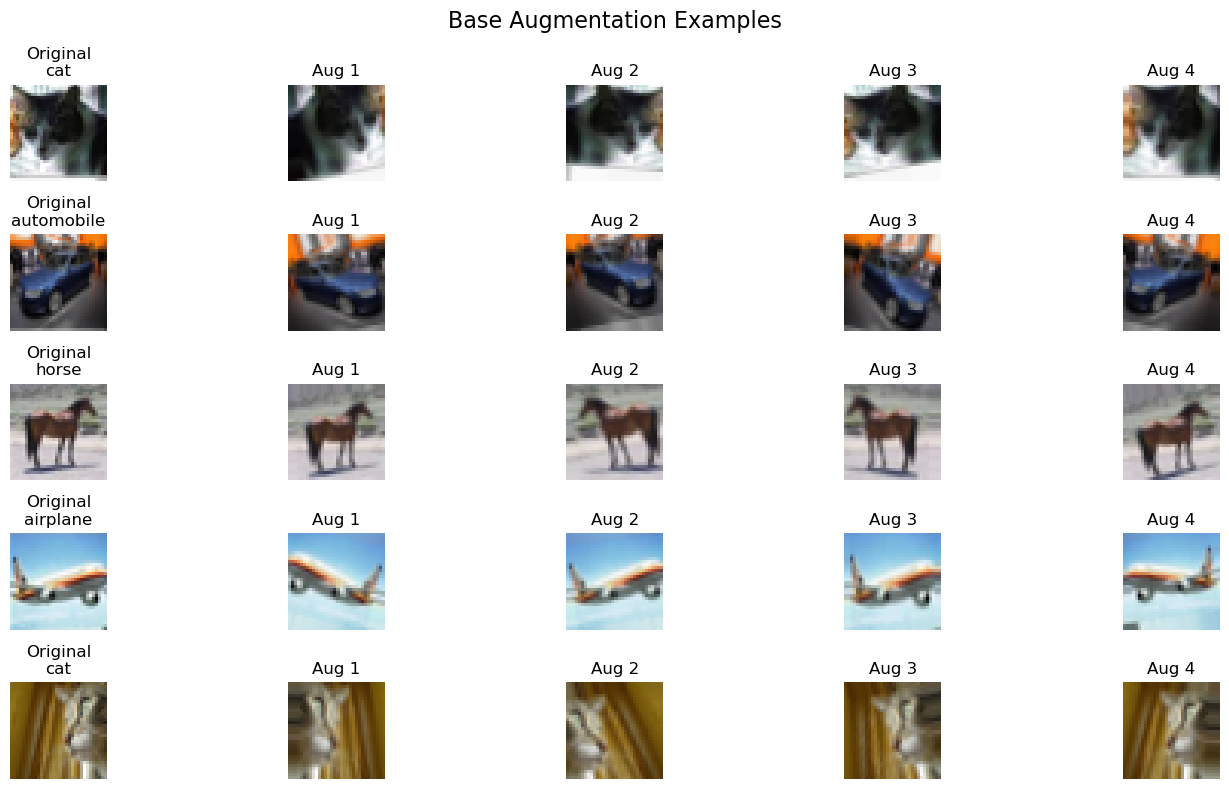

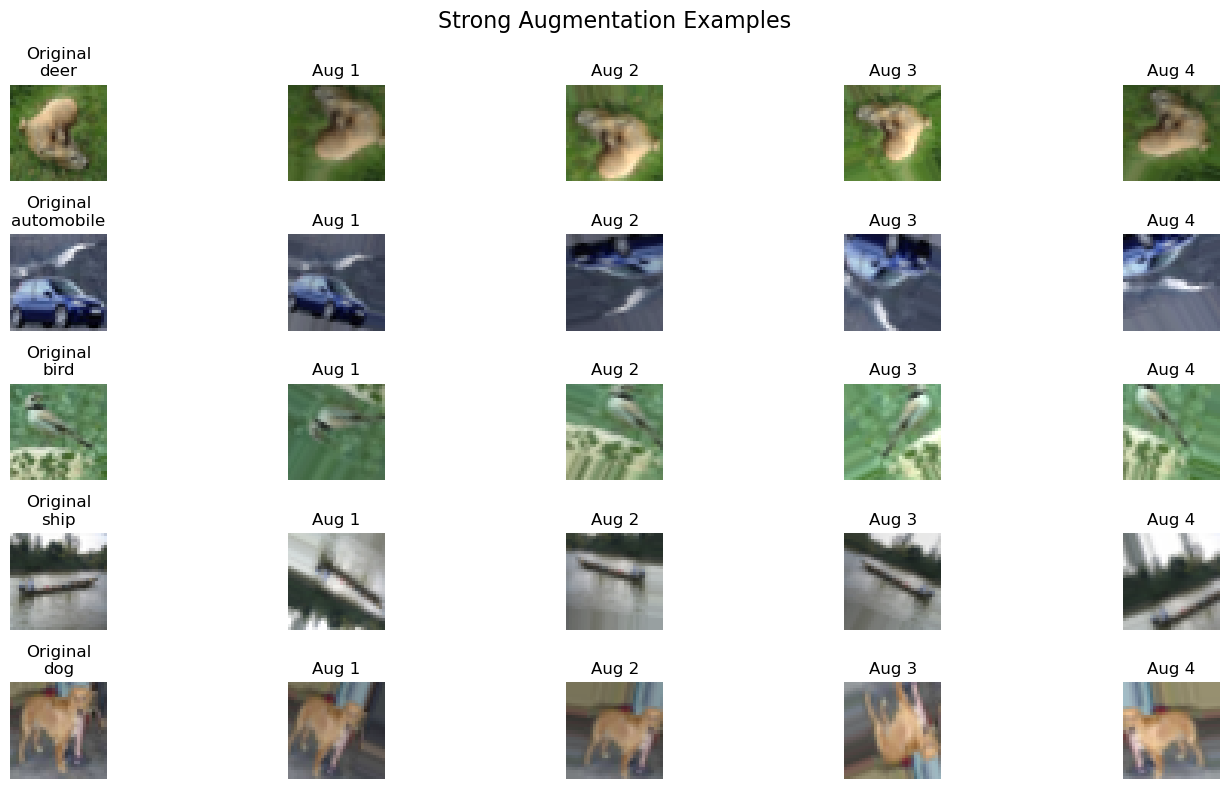

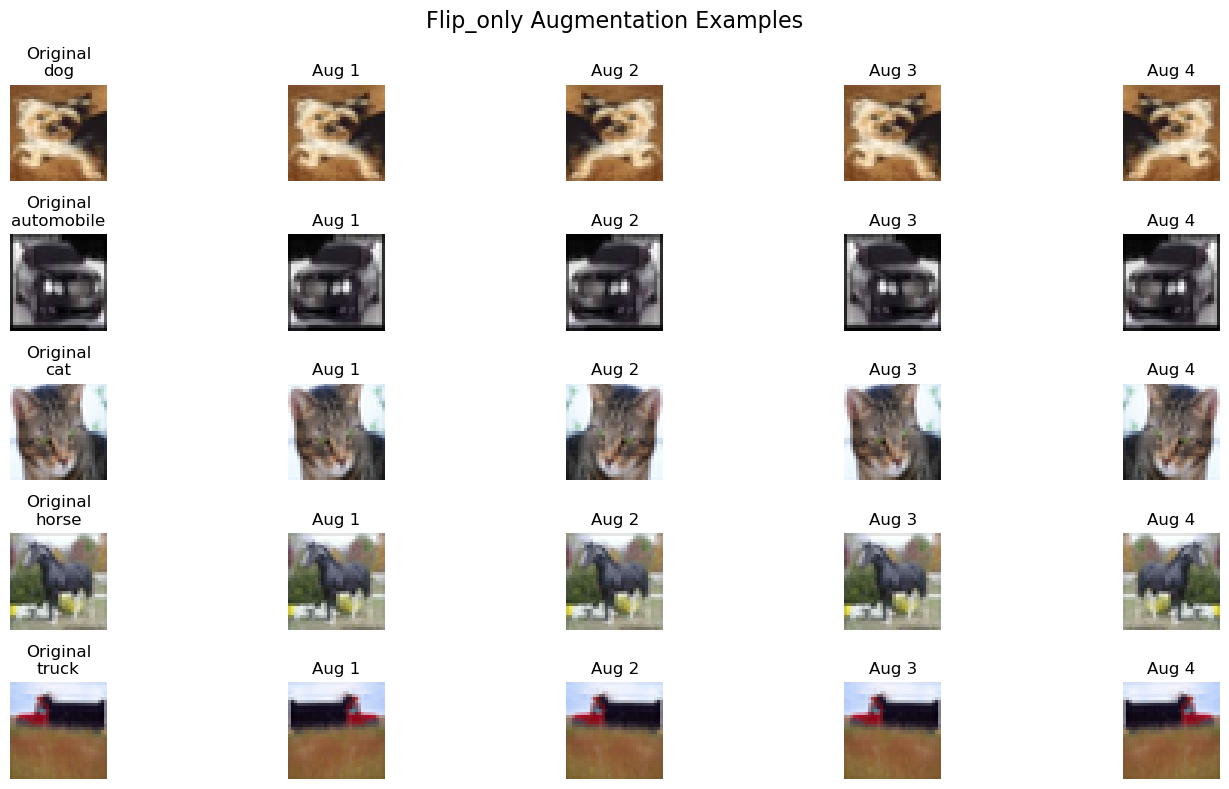

In [10]:
def visualize_augmentations(images: np.ndarray, labels: np.ndarray, 
                           generator: ImageDataGenerator, 
                           augmentation_type: str, num_samples: int = 5) -> None:
    """可视化增强后的图像"""
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(f'{augmentation_type} Augmentation Examples', fontsize=16)
    
    # 选择一些样本
    sample_indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        original_image = images[idx]
        original_label = labels[idx][0]
        
        # 应用增强
        augmented_images = []
        for _ in range(4):  # 生成4个增强版本
            aug_img = generator.random_transform(original_image.astype('float32'))
            augmented_images.append(aug_img)
        
        # 绘制原始图像
        plt.subplot(num_samples, 5, i*5 + 1)
        plt.imshow(original_image.astype('uint8'))
        plt.title(f'Original\n{CLASS_NAMES[original_label]}')
        plt.axis('off')
        
        # 绘制增强图像
        for j, aug_img in enumerate(augmented_images):
            plt.subplot(num_samples, 5, i*5 + j + 2)
            plt.imshow(aug_img.astype('uint8'))
            plt.title(f'Aug {j+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化不同增强效果
print("Visualizing augmentation techniques...")
for aug_type, generator in augmentation_generators.items():
    if aug_type != 'none':  # 跳过无增强
        visualize_augmentations(x_train, y_train, generator, aug_type.capitalize())

 6. Class Balancing Techniques

In [12]:
def analyze_class_imbalance(labels: np.ndarray) -> None:
    """分析类别不平衡"""
    class_counts = Counter(labels.flatten())
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count
    
    print(f"Maximum class count: {max_count}")
    print(f"Minimum class count: {min_count}")
    print(f"Imbalance ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 2.0:
        print("Warning: Significant class imbalance detected!")
    else:
        print("Class distribution is relatively balanced")

analyze_class_imbalance(y_train)

Maximum class count: 4000
Minimum class count: 4000
Imbalance ratio: 1.00
Class distribution is relatively balanced


 7. Data Balancing Strategies

In [13]:
def apply_class_balancing(x_data: np.ndarray, y_data: np.ndarray, 
                         strategy: str = 'oversample') -> Tuple[np.ndarray, np.ndarray]:
    """应用类别平衡策略"""
    
    y_flat = y_data.flatten()
    
    if strategy == 'oversample':
        # 过采样少数类
        class_counts = Counter(y_flat)
        max_count = max(class_counts.values())
        
        x_balanced_list = []
        y_balanced_list = []
        
        for class_id in range(len(CLASS_NAMES)):
            class_mask = (y_flat == class_id)
            x_class = x_data[class_mask]
            y_class = y_data[class_mask]
            
            # 如果需要过采样
            if len(x_class) < max_count:
                num_to_sample = max_count - len(x_class)
                indices = np.random.choice(len(x_class), num_to_sample, replace=True)
                x_oversampled = x_class[indices]
                y_oversampled = y_class[indices]
                
                x_balanced_list.append(np.concatenate([x_class, x_oversampled]))
                y_balanced_list.append(np.concatenate([y_class, y_oversampled]))
            else:
                x_balanced_list.append(x_class)
                y_balanced_list.append(y_class)
        
        x_balanced = np.concatenate(x_balanced_list)
        y_balanced = np.concatenate(y_balanced_list)
        
    elif strategy == 'undersample':
        # 欠采样多数类
        class_counts = Counter(y_flat)
        min_count = min(class_counts.values())
        
        x_balanced_list = []
        y_balanced_list = []
        
        for class_id in range(len(CLASS_NAMES)):
            class_mask = (y_flat == class_id)
            x_class = x_data[class_mask]
            y_class = y_data[class_mask]
            
            # 随机选择样本
            indices = np.random.choice(len(x_class), min_count, replace=False)
            x_balanced_list.append(x_class[indices])
            y_balanced_list.append(y_class[indices])
        
        x_balanced = np.concatenate(x_balanced_list)
        y_balanced = np.concatenate(y_balanced_list)
    
    else:
        # 不进行平衡
        x_balanced, y_balanced = x_data, y_data
    
    # 打乱数据
    indices = np.random.permutation(len(x_balanced))
    return x_balanced[indices], y_balanced[indices]

# 应用平衡策略
print("Applying class balancing...")
x_train_balanced, y_train_balanced = apply_class_balancing(x_train, y_train, 'oversample')

# 分析平衡后的分布
print("\nAfter balancing:")
balanced_dist = analyze_class_distribution(y_train_balanced, "Balanced Training")


Applying class balancing...

After balancing:

Balanced Training Class Distribution:
----------------------------------------
airplane    :  4000 samples ( 10.0%)
automobile  :  4000 samples ( 10.0%)
bird        :  4000 samples ( 10.0%)
cat         :  4000 samples ( 10.0%)
deer        :  4000 samples ( 10.0%)
dog         :  4000 samples ( 10.0%)
frog        :  4000 samples ( 10.0%)
horse       :  4000 samples ( 10.0%)
ship        :  4000 samples ( 10.0%)
truck       :  4000 samples ( 10.0%)


8. Data Normalization

In [15]:
def normalize_data(x_data: np.ndarray, mode: str = 'standard') -> np.ndarray:
    """数据标准化"""
    x_normalized = x_data.astype('float32')
    
    if mode == 'standard':
        # 标准归一化 [0, 255] -> [0, 1]
        x_normalized /= 255.0
        
    elif mode == 'mean_std':
        # 均值标准差归一化
        mean = np.mean(x_normalized, axis=(0, 1, 2))
        std = np.std(x_normalized, axis=(0, 1, 2))
        x_normalized = (x_normalized - mean) / (std + 1e-7)
        
    elif mode == 'minmax':
        # Min-Max归一化
        x_normalized = (x_normalized - x_normalized.min()) / (x_normalized.max() - x_normalized.min())
    
    return x_normalized

# 应用归一化
print("Normalizing data...")
x_train_norm = normalize_data(x_train_balanced, 'standard')
x_val_norm = normalize_data(x_val, 'standard')
x_test_norm = normalize_data(x_test, 'standard')

print(f"Normalized training range: [{x_train_norm.min():.3f}, {x_train_norm.max():.3f}]")
print(f"Normalized validation range: [{x_val_norm.min():.3f}, {x_val_norm.max():.3f}]")


Normalizing data...
Normalized training range: [0.000, 1.000]
Normalized validation range: [0.000, 1.000]


9. Create Data Generators

In [16]:
def create_data_generators(x_train: np.ndarray, y_train: np.ndarray,
                          x_val: np.ndarray, y_val: np.ndarray,
                          batch_size: int = 32) -> Tuple:
    """创建训练和验证数据生成器"""
    
    # 转换为分类格式
    y_train_categorical = to_categorical(y_train, len(CLASS_NAMES))
    y_val_categorical = to_categorical(y_val, len(CLASS_NAMES))
    
    # 训练数据生成器（带增强）
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1,
        fill_mode='nearest'
    )
    
    # 验证数据生成器（不带增强）
    val_datagen = ImageDataGenerator()
    
    # 创建生成器
    train_generator = train_datagen.flow(
        x_train, y_train_categorical,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_generator = val_datagen.flow(
        x_val, y_val_categorical,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_generator, val_generator, train_datagen, val_datagen

# 创建数据生成器
BATCH_SIZE = 64
train_gen, val_gen, train_datagen, val_datagen = create_data_generators(
    x_train_norm, y_train_balanced, x_val_norm, y_val, BATCH_SIZE
)

print("Data generators created successfully!")
print(f"Training batches per epoch: {len(train_gen)}")
print(f"Validation batches: {len(val_gen)}")

Data generators created successfully!
Training batches per epoch: 625
Validation batches: 157


10. Save Augmented Data

In [18]:
def save_augmented_data(x_train: np.ndarray, y_train: np.ndarray,
                       x_val: np.ndarray, y_val: np.ndarray,
                       x_test: np.ndarray, y_test: np.ndarray,
                       output_path: str = '../data/augmented') -> None:
    """保存增强后的数据"""
    
    os.makedirs(output_path, exist_ok=True)
    
    # 保存数据
    np.save(os.path.join(output_path, 'x_train_aug.npy'), x_train)
    np.save(os.path.join(output_path, 'y_train_aug.npy'), y_train)
    np.save(os.path.join(output_path, 'x_val_aug.npy'), x_val)
    np.save(os.path.join(output_path, 'y_val_aug.npy'), y_val)
    np.save(os.path.join(output_path, 'x_test_aug.npy'), x_test)
    np.save(os.path.join(output_path, 'y_test_aug.npy'), y_test)
    
    # 保存类别名称
    with open(os.path.join(output_path, 'class_names.txt'), 'w', encoding='utf-8') as f:
        for name in CLASS_NAMES:
            f.write(f"{name}\n")
    
    print(f"Augmented data saved to {output_path}")

# 保存数据
save_augmented_data(x_train_norm, y_train_balanced, x_val_norm, y_val, x_test_norm, y_test)

Augmented data saved to ../data/augmented


11. Summary Report


In [19]:
def generate_augmentation_summary() -> None:
    """生成数据增强总结报告"""
    
    print("=" * 60)
    print("DATA AUGMENTATION SUMMARY REPORT")
    print("=" * 60)
    
    print(f"Original training samples: {len(x_train)}")
    print(f"Augmented training samples: {len(x_train_balanced)}")
    print(f"Validation samples: {len(x_val)}")
    print(f"Test samples: {len(x_test)}")
    
    print(f"\nAugmentation techniques applied:")
    print("  - Random rotation (0-15 degrees)")
    print("  - Random width/height shift (10%)")
    print("  - Horizontal flipping")
    print("  - Random zoom (10%)")
    
    print(f"\nClass balancing: Oversampling applied")
    print(f"Normalization: Standard scaling [0, 1]")
    
    print(f"\nBatch size: {BATCH_SIZE}")
    print(f"Training batches per epoch: {len(train_gen)}")
    print(f"Input shape: {x_train_norm.shape[1:]}")
    
    print("=" * 60)

# 生成总结
generate_augmentation_summary()

print("Data augmentation completed successfully!")

DATA AUGMENTATION SUMMARY REPORT
Original training samples: 40000
Augmented training samples: 40000
Validation samples: 10000
Test samples: 10000

Augmentation techniques applied:
  - Random rotation (0-15 degrees)
  - Random width/height shift (10%)
  - Horizontal flipping
  - Random zoom (10%)

Class balancing: Oversampling applied
Normalization: Standard scaling [0, 1]

Batch size: 64
Training batches per epoch: 625
Input shape: (32, 32, 3)
Data augmentation completed successfully!
